# Is it possible to predict which team will win based on the first 10min of the game?

# Introduction

*The data includes first 10 min stats from League of Legends Game including the target value whether the blue team won or not. The goal is to analyse features to predict winning team and also get statistical output of which features are more important in winning the game in the first 10 min. This is important because it helps gamers to better strategize the game. Then, the process was to apply several machine learning techniques such as Decision Tree, Logistic Regression, and so on. Interestingly, Logistic Regression had the highest accuracy. We also conducted methods such as cross validation and GridSearchCV to find the best parameters for each model. Additionally, Roc Auc curve was used to improve our model accuracy and to look for model overfitting or underfitting.*

# Background

Similarly, a data scientist Shayaan Jagtap wrote about predicting game outcomes by looking at key features such as kills, gold differences, etc. Jagtap conducted a Logistics Regression with a 75.78% accuracy, one of best models of highest accuracy, in the first 15 mins of the game, which is very close to our result. Interestingly, Jagtap found out that the chance of correctly predicting the winning team in the early game was not very high since ‘Your enemy could always turn the tide.’ 

# EDA

In [416]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [417]:
# Random Seed
SEED = 42
np.random.seed = SEED

In [418]:
dataurl = '../datasets/high_diamond_ranked_10min.csv'

In [419]:
df = pd.read_csv(dataurl)
df.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [420]:
print('Shape of Data, # of Rows {} and # of Columns {}'.format(df.shape[0], df.shape[1]))

Shape of Data, # of Rows 9879 and # of Columns 40


In [421]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

In [422]:
df.iloc[:, 2:20].columns

Index(['blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood', 'blueKills',
       'blueDeaths', 'blueAssists', 'blueEliteMonsters', 'blueDragons',
       'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin'],
      dtype='object')

In [423]:
df.iloc[:, 21:].columns

Index(['redWardsPlaced', 'redWardsDestroyed', 'redFirstBlood', 'redKills',
       'redDeaths', 'redAssists', 'redEliteMonsters', 'redDragons',
       'redHeralds', 'redTowersDestroyed', 'redTotalGold', 'redAvgLevel',
       'redTotalExperience', 'redTotalMinionsKilled',
       'redTotalJungleMinionsKilled', 'redGoldDiff', 'redExperienceDiff',
       'redCSPerMin', 'redGoldPerMin'],
      dtype='object')

*The data is found on Kaggle. The data set contained 9879 observations with 40 features. there are 19 features per team except gameid and the target variable as indicated above. <br>*
*Data Source: https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min <br>*

*Checking gameid uniqueness to acertain all games are independent.*

In [424]:
len(df['gameId'].unique()) == df.shape[0]

True

*Distribution of wins*

In [425]:
df['blueWins'].value_counts()

0    4949
1    4930
Name: blueWins, dtype: int64

*blueWins is our target variable, we want to make sure the data is balanced.*

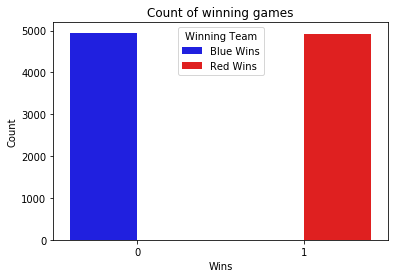

In [426]:
ax = sns.countplot(df['blueWins'], hue=df['blueWins'], palette=['blue', 'red'])
ax.set(xlabel='Wins', ylabel='Count')
ax.legend(title='Winning Team', loc='upper center', labels=['Blue Wins', 'Red Wins'])
ax.set_title('Count of winning games')
plt.show()

## Data Cleaning

*Dropping `gameId` since it is a unique value for each observation.*

In [427]:
df = df.drop(columns='gameId')

In [428]:
corr = df.corr()

#### Checking correlation between features

In [429]:
columns = df.columns
for i in columns:
    for j in columns:
        if abs(df[i].corr(df[j])) >= 0.95:
            if i != j:
                print([i, j, df[i].corr(df[j])])
                columns = columns.drop(i)

['blueFirstBlood', 'redFirstBlood', -1.0]
['blueKills', 'redDeaths', 1.0]
['blueDeaths', 'redKills', 1.0]
['blueTotalGold', 'blueGoldPerMin', 1.0]
['blueTotalMinionsKilled', 'blueCSPerMin', 1.0]
['blueGoldDiff', 'redGoldDiff', -1.0]
['blueExperienceDiff', 'redExperienceDiff', -1.0]
['redTotalGold', 'redGoldPerMin', 1.0]
['redTotalMinionsKilled', 'redCSPerMin', 0.9999999999999996]


In [430]:
print((df['blueKills'] == df['redDeaths']).value_counts())

print((df['blueDeaths'] == df['redKills']).value_counts())

True    9879
dtype: int64
True    9879
dtype: int64


In [431]:
print((df['redTotalGold'] / 10 == df['redGoldPerMin']).value_counts())
print((df['blueTotalGold'] / 10 == df['blueGoldPerMin']).value_counts())
print((df['redTotalMinionsKilled'] / 10 == df['redCSPerMin']).value_counts())
print((df['blueTotalMinionsKilled'] / 10 == df['blueCSPerMin']).value_counts())
print((df['redEliteMonsters'] == (df['redDragons'] + df['redHeralds'])).value_counts())
print((df['blueEliteMonsters'] == (df['blueDragons'] + df['blueHeralds'])).value_counts())
print((df['blueGoldDiff'] == (df['blueTotalGold'] - df['redTotalGold'])).value_counts())
print((df['redGoldDiff'] == (df['redTotalGold'] - df['blueTotalGold'])).value_counts())
print((df['blueExperienceDiff'] == (df['blueTotalExperience'] - df['redTotalExperience'])).value_counts())
print((df['redExperienceDiff'] == (df['redTotalExperience'] - df['blueTotalExperience'])).value_counts())

True    9879
dtype: int64
True    9879
dtype: int64
True    9879
dtype: int64
True    9879
dtype: int64
True    9879
dtype: int64
True    9879
dtype: int64
True    9879
dtype: int64
True    9879
dtype: int64
True    9879
dtype: int64
True    9879
dtype: int64


*we can see above that variables with correlation of 1 or -1 are repeated, so we can minimize them later*

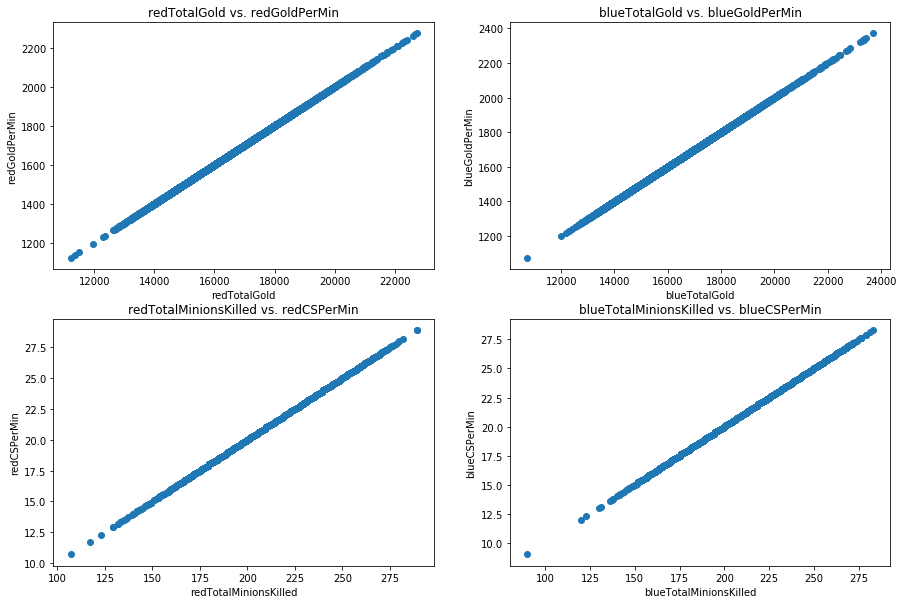

In [432]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))


ax[0,0].scatter('redTotalGold','redGoldPerMin', data=df)
ax[0,0].set_title('redTotalGold vs. redGoldPerMin')
ax[0,0].set_ylabel('redGoldPerMin')
ax[0,0].set_xlabel('redTotalGold')

ax[0,1].scatter('blueTotalGold','blueGoldPerMin', data=df)
ax[0,1].set_title('blueTotalGold vs. blueGoldPerMin')
ax[0,1].set_ylabel('blueGoldPerMin')
ax[0,1].set_xlabel('blueTotalGold')

ax[1,0].scatter('redTotalMinionsKilled','redCSPerMin', data=df)
ax[1,0].set_title('redTotalMinionsKilled vs. redCSPerMin')
ax[1,0].set_ylabel('redCSPerMin')
ax[1,0].set_xlabel('redTotalMinionsKilled')

ax[1,1].scatter('blueTotalMinionsKilled','blueCSPerMin', data=df)
ax[1,1].set_title('blueTotalMinionsKilled vs. blueCSPerMin')
ax[1,1].set_ylabel('blueCSPerMin')
ax[1,1].set_xlabel('blueTotalMinionsKilled')

plt.show()

*Dealing with features with high correlation*
- `blueFirstBlood` and `redFirstBlood` are inversely correlated since only one team can score first blood in the game. Dropping one feature
- `blueKills` and `redDeaths`, and `blueDeaths` and `redKills` are perfectly correlated and have same data since the game is only between two teams.
- `redCSPerMin`, `redGoldPerMin`, `redExperienceDiff`, `redGoldDiff`, `blueGoldDiff`, `blueCSPerMin`, `blueExperienceDiff`, `redEliteMonsters`, `blueEliteMonsters` and `blueGoldPerMin`, are all derived values

In [433]:
df = df.drop(columns=['redFirstBlood', 'redDeaths', 'redKills', 'redGoldPerMin', 'blueGoldPerMin', 'redCSPerMin', 'blueCSPerMin', 'blueGoldDiff', 'redGoldDiff', 'blueExperienceDiff', 'redExperienceDiff', 'redEliteMonsters', 'blueEliteMonsters'])

In [434]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   blueWins                      9879 non-null   int64  
 1   blueWardsPlaced               9879 non-null   int64  
 2   blueWardsDestroyed            9879 non-null   int64  
 3   blueFirstBlood                9879 non-null   int64  
 4   blueKills                     9879 non-null   int64  
 5   blueDeaths                    9879 non-null   int64  
 6   blueAssists                   9879 non-null   int64  
 7   blueDragons                   9879 non-null   int64  
 8   blueHeralds                   9879 non-null   int64  
 9   blueTowersDestroyed           9879 non-null   int64  
 10  blueTotalGold                 9879 non-null   int64  
 11  blueAvgLevel                  9879 non-null   float64
 12  blueTotalExperience           9879 non-null   int64  
 13  blu

In [435]:
clean_corr = df.corr()
clean_corr['blueWins'].sort_values(ascending=False)

blueWins                        1.000000
blueTotalGold                   0.417213
blueTotalExperience             0.396141
blueAvgLevel                    0.357820
blueKills                       0.337358
blueAssists                     0.276685
blueTotalMinionsKilled          0.224909
blueDragons                     0.213768
blueFirstBlood                  0.201769
blueTotalJungleMinionsKilled    0.131445
blueTowersDestroyed             0.115566
blueHeralds                     0.092385
blueWardsDestroyed              0.044247
blueWardsPlaced                 0.000087
redWardsPlaced                 -0.023671
redWardsDestroyed              -0.055400
redHeralds                     -0.097172
redTowersDestroyed             -0.103696
redTotalJungleMinionsKilled    -0.110994
redDragons                     -0.209516
redTotalMinionsKilled          -0.212171
redAssists                     -0.271047
blueDeaths                     -0.339297
redAvgLevel                    -0.352127
redTotalExperien

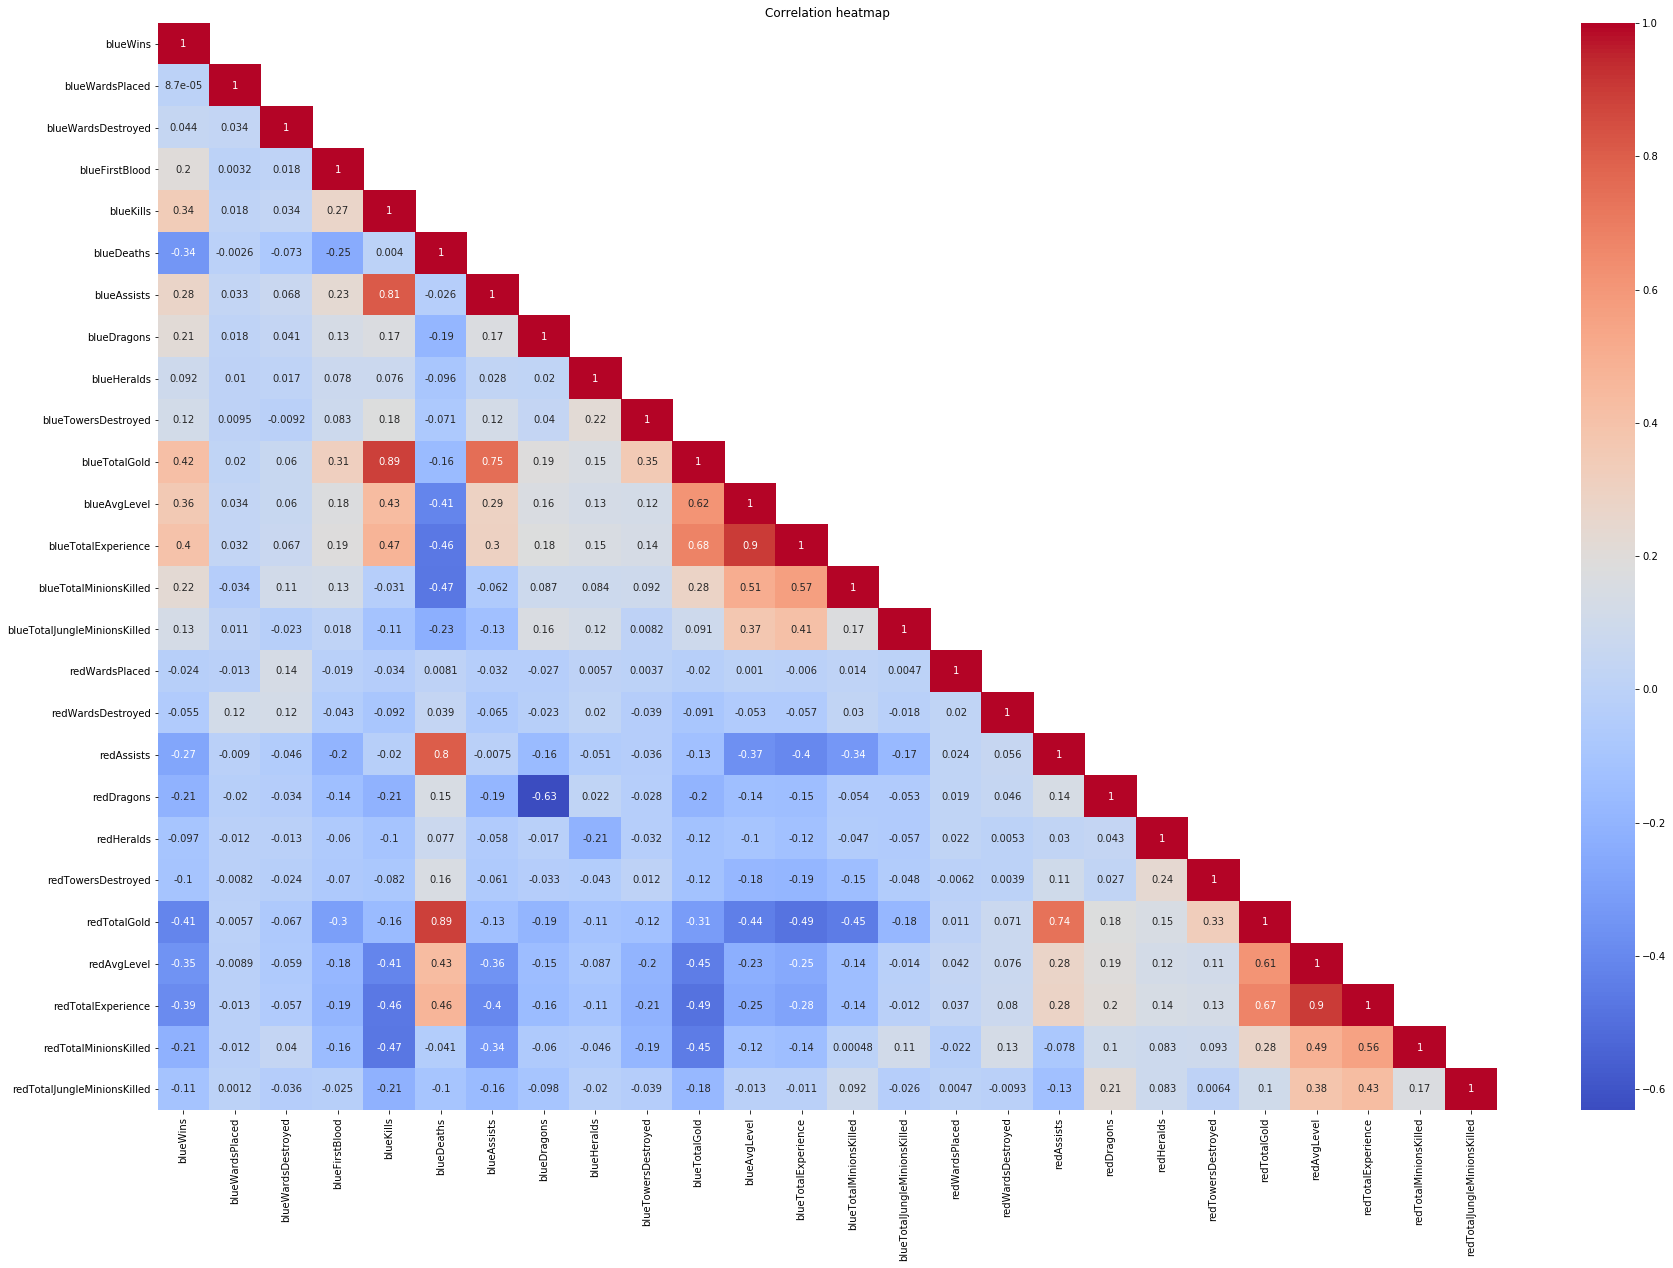

In [436]:
f, ax = plt.subplots(figsize= (30, 20))
lower = clean_corr.where(np.tril(np.ones(clean_corr.shape)).astype(np.bool))
hmap=sns.heatmap(lower,cmap="coolwarm", annot=True)
ax.set_title('Correlation heatmap')
plt.savefig('clean-corr-half.png')

*['blueTotalGold' , 'blueTotalExperience', blueAvgLevel, 'blueKills', 'blueAssists', 'blueTotalMinionsKilled', 'blueDragons', 'blueFirstBlood'], those feature have more higher corrlation than other features with blueWins*

### Identify Missing Data

In [437]:
df.describe()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,...,redWardsDestroyed,redAssists,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled
count,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,...,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,0.499038,22.288288,2.824881,0.504808,6.183925,6.137666,6.645106,0.361980,0.187974,0.051422,...,2.723150,6.662112,0.413098,0.160036,0.043021,16489.041401,6.925316,17961.730438,217.349226,51.313088
std,0.500024,18.019177,2.174998,0.500002,3.011028,2.933818,4.064520,0.480597,0.390712,0.244369,...,2.138356,4.060612,0.492415,0.366658,0.216900,1490.888406,0.305311,1198.583912,21.911668,10.027885
min,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,11212.000000,4.800000,10465.000000,107.000000,4.000000
25%,0.000000,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,...,1.000000,4.000000,0.000000,0.000000,0.000000,15427.500000,6.800000,17209.500000,203.000000,44.000000
50%,0.000000,16.000000,3.000000,1.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,...,2.000000,6.000000,0.000000,0.000000,0.000000,16378.000000,7.000000,17974.000000,218.000000,51.000000
75%,1.000000,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,0.000000,0.000000,...,4.000000,9.000000,1.000000,0.000000,0.000000,17418.500000,7.200000,18764.500000,233.000000,57.000000
max,1.000000,250.000000,27.000000,1.000000,22.000000,22.000000,29.000000,1.000000,1.000000,4.000000,...,24.000000,28.000000,1.000000,1.000000,2.000000,22732.000000,8.200000,22269.000000,289.000000,92.000000


In [438]:
df.isnull().sum().sum()

0

In [439]:
df.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,...,redWardsDestroyed,redAssists,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled
0,0,28,2,1,9,6,11,0,0,0,...,6,8,0,0,0,16567,6.8,17047,197,55
1,0,12,1,0,5,5,5,0,0,0,...,1,2,1,1,1,17620,6.8,17438,240,52
2,0,15,0,0,7,11,4,1,0,0,...,3,14,0,0,0,17285,6.8,17254,203,28
3,0,43,1,0,4,5,5,0,1,0,...,2,10,0,0,0,16478,7.0,17961,235,47
4,0,75,4,0,6,6,6,0,0,0,...,2,7,1,0,0,17404,7.0,18313,225,67


In [440]:
df.applymap(np.isreal).all().sum()

26

In [441]:
df.applymap(lambda x: isinstance(x, (int, float))).all().sum()

26

*For missing value, first see use df.describe() to see min/max in each columns. ensure each feature in right range. Then, we use df.isnull() to see pandas that can identify any missing value. Since our data contain all numeric features, we also use applymap function with np.isreal or isinstance, search for each row and each column to see if there any missing value can find. Base on the result, our data do not have any missing values.*

In [442]:
print('Lenght of columms {}'.format(len(df.columns)))

Lenght of columms 26


In [443]:
df.columns

Index(['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood',
       'blueKills', 'blueDeaths', 'blueAssists', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'redWardsPlaced', 'redWardsDestroyed',
       'redAssists', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalGold', 'redAvgLevel', 'redTotalExperience',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled'],
      dtype='object')

### Outliers

In [444]:
def plot_violinplot(df,ax_key):
    df = pd.melt(df, id_vars='blueWins', var_name='Features', value_name='Values')
    sns.violinplot(x='Features', y='Values', hue='blueWins', data=df, split=True,
               inner='quart', ax=ax[ax_key], palette='muted').set_title('showing outliers using voilin plot ')
    fig.autofmt_xdate(rotation=45)

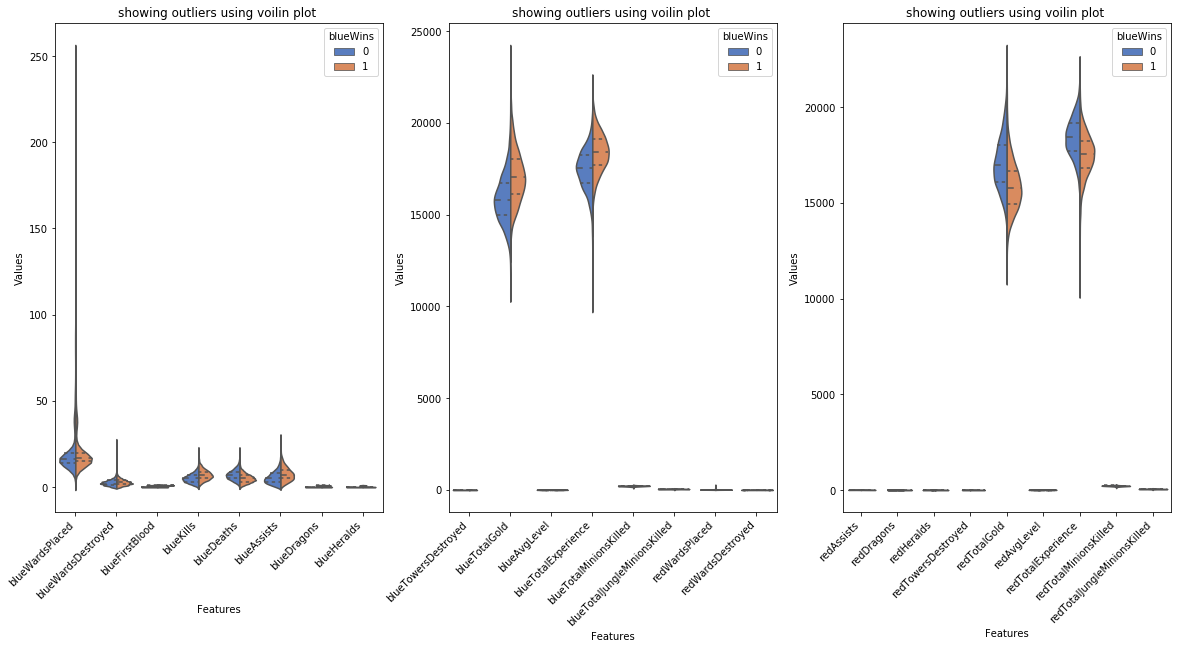

In [445]:
fig, ax = plt.subplots(1,3,figsize=(20,10))
data = df.loc[:, df.columns != 'blueWins']
data = pd.DataFrame(data = data, columns = data.columns)
data1 = pd.concat([df.blueWins, data.iloc[:, 0:8]], axis=1)
plot_violinplot(data1,0)
data2 = pd.concat([df.blueWins, data.iloc[:, 8:16]], axis=1)
plot_violinplot(data2,1)
data3 = pd.concat([df.blueWins, data.iloc[:, 16:]], axis=1)
plot_violinplot(data3,2)
plt.show()

*let's plot with standardized value to see better visualization*

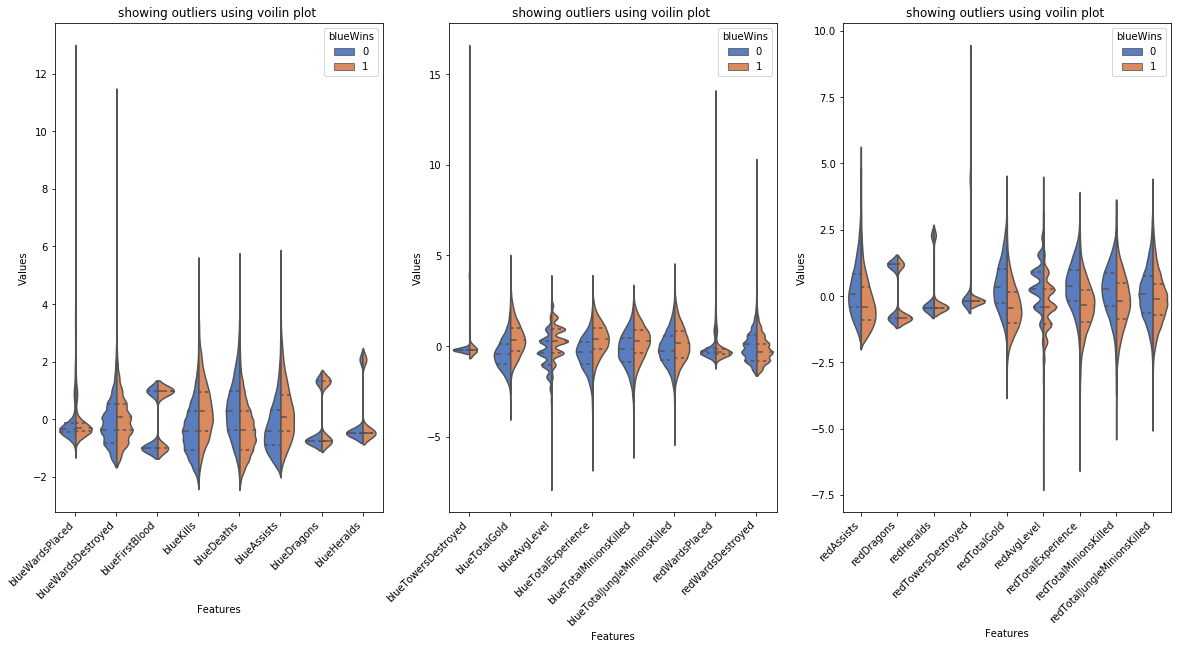

In [446]:
fig, ax = plt.subplots(1,3,figsize=(20,10))
data = df.loc[:, df.columns != 'blueWins']
data_std = StandardScaler().fit_transform(data)
data_std = pd.DataFrame(data = data_std, columns = data.columns)
data1 = pd.concat([df.blueWins, df_std.iloc[:, 0:8]], axis=1)
plot_violinplot(data1,0)
data2 = pd.concat([df.blueWins, df_std.iloc[:, 8:16]], axis=1)
plot_violinplot(data2,1)
data3 = pd.concat([df.blueWins, df_std.iloc[:, 16:]], axis=1)
plot_violinplot(data3,2)
plt.show()

*Our data contain outliers. But since those are about game performance for each group, like red group performed well in one game, but performance bad in other games. we decide to keep those outliers since there is no unit. and these outliers could better give feedback on which team will win the game.*

In [447]:
from sklearn.model_selection import train_test_split

In [448]:
y = df['blueWins']
X = df.loc[:, df.columns != 'blueWins']

In [449]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)

In [450]:
test_df = pd.concat([X_test, y_test], axis=1)

In [451]:
train_df = pd.concat([X_train, y_train], axis=1)

In [452]:
train_df.to_csv('../datasets/train.csv', index=False)
test_df.to_csv('../datasets/test.csv', index = False)

In [453]:
print('Labels count in y: ', np.bincount(y))
print('Labels count in y_train ', np.bincount(y_train))
print('Labels count in y_test', np.bincount(y_test))

Labels count in y:  [4949 4930]
Labels count in y_train  [3464 3451]
Labels count in y_test [1485 1479]


*The data has been split into training and testing set. The training data contain 6915 observations and the test data contain 2964 observations. we also use stratify=y to eunsures that both training and test datasets have the same class proportions as the original dataset.*